In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 10.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep7/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep7/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep7/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Fixing dates (https://www.kaggle.com/competitions/playground-series-s3e7/discussion/386655)
train['arrival_year_month'] = pd.to_datetime(train['arrival_year'].astype(str) + train['arrival_month'].astype(str), format = '%Y%m')
test['arrival_year_month'] = pd.to_datetime(test['arrival_year'].astype(str) + test['arrival_month'].astype(str), format = '%Y%m')

train.loc[train.arrival_date > train.arrival_year_month.dt.days_in_month, 'arrival_date'] = train.arrival_year_month.dt.days_in_month
test.loc[test.arrival_date > test.arrival_year_month.dt.days_in_month, 'arrival_date'] = test.arrival_year_month.dt.days_in_month

train.drop(columns = 'arrival_year_month', inplace = True)
test.drop(columns = 'arrival_year_month', inplace = True)

train['low_price_flag'] = np.where(train['avg_price_per_room'] < 30, 1, 0)
train['segment_0'] = np.where(train['market_segment_type'] == 0, 1, 0)
train['segment_1'] = np.where(train['market_segment_type'] == 1, 1, 0)
train['total_guests'] = train['no_of_adults'] + train['no_of_children']
train['stay_length'] = train['no_of_weekend_nights'] + train['no_of_week_nights']
train['stay_during_weekend'] = np.where(train['no_of_weekend_nights'] > 0, 1, 0)
train['quarter_1'] = np.where(train['arrival_month'] <= 3, 1, 0)
train['quarter_2'] = np.where(((train['arrival_month'] >= 4) & (train['arrival_month'] <= 6)), 1, 0)
train['quarter_3'] = np.where(((train['arrival_month'] >= 7) & (train['arrival_month'] <= 9)), 1, 0)
train['quarter_4'] = np.where(train['arrival_month'] >= 10, 1, 0)
train['segment_0_feature_1'] = np.where(((train['market_segment_type'] == 0) & (train['lead_time'] <= 90)), 1, 0)
train['segment_0_feature_2'] = np.where(((train['market_segment_type'] == 0) & (train['avg_price_per_room'] > 98)), 1, 0)
train['segment_1_feature_1'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] == 0)), 1, 0)
train['segment_1_feature_2'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] > 0) & (train['lead_time'] <= 150)), 1, 0)
train['segment_0_year_flag'] = np.where(((train['market_segment_type'] == 0) & (train['arrival_year'] == 2018)), 1, 0)
train['segment_1_year_flag'] = np.where(((train['market_segment_type'] == 1) & (train['arrival_year'] == 2018)), 1, 0)
train['price_lead_time_flag'] = np.where(((train['avg_price_per_room'] > 100) & (train['lead_time'] > 150)), 1, 0)

test['low_price_flag'] = np.where(test['avg_price_per_room'] < 30, 1, 0)
test['segment_0'] = np.where(test['market_segment_type'] == 0, 1, 0)
test['segment_1'] = np.where(test['market_segment_type'] == 1, 1, 0)
test['total_guests'] = test['no_of_adults'] + test['no_of_children']
test['stay_length'] = test['no_of_weekend_nights'] + test['no_of_week_nights']
test['stay_during_weekend'] = np.where(test['no_of_weekend_nights'] > 0, 1, 0)
test['quarter_1'] = np.where(test['arrival_month'] <= 3, 1, 0)
test['quarter_2'] = np.where(((test['arrival_month'] >= 4) & (test['arrival_month'] <= 6)), 1, 0)
test['quarter_3'] = np.where(((test['arrival_month'] >= 7) & (test['arrival_month'] <= 9)), 1, 0)
test['quarter_4'] = np.where(test['arrival_month'] >= 10, 1, 0)
test['segment_0_feature_1'] = np.where(((test['market_segment_type'] == 0) & (test['lead_time'] <= 90)), 1, 0)
test['segment_0_feature_2'] = np.where(((test['market_segment_type'] == 0) & (test['avg_price_per_room'] > 98)), 1, 0)
test['segment_1_feature_1'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] == 0)), 1, 0)
test['segment_1_feature_2'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] > 0) & (test['lead_time'] <= 150)), 1, 0)
test['segment_0_year_flag'] = np.where(((test['market_segment_type'] == 0) & (test['arrival_year'] == 2018)), 1, 0)
test['segment_1_year_flag'] = np.where(((test['market_segment_type'] == 1) & (test['arrival_year'] == 2018)), 1, 0)
test['price_lead_time_flag'] = np.where(((test['avg_price_per_room'] > 100) & (test['lead_time'] > 150)), 1, 0)

In [15]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,low_price_flag,segment_0,segment_1,total_guests,stay_length,stay_during_weekend,quarter_1,quarter_2,quarter_3,quarter_4,segment_0_feature_1,segment_0_feature_2,segment_1_feature_1,segment_1_feature_2,segment_0_year_flag,segment_1_year_flag,price_lead_time_flag
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,0,0,1,2,2,0,1,0,0,0,0,0,1,0,0,1,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,0,1,0,2,3,1,0,0,1,0,0,0,0,0,1,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,0,1,0,2,1,0,0,0,0,1,0,0,0,0,1,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,0,0,1,1,2,0,0,0,0,1,0,0,1,0,0,1,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,0,1,0,2,1,1,0,0,0,1,0,1,0,0,1,0,0


In [3]:
from sklearn.kernel_approximation import RBFSampler

X = train[['avg_price_per_room', 'lead_time']]

rbf_feature = RBFSampler(gamma = 1, random_state = 1)
A_features = rbf_feature.fit_transform(A)

In [4]:
A_features[:, 0:3]

array([[-0.09208778, -0.14120205, -0.13776265],
       [-0.14135896, -0.10259444, -0.0374632 ],
       [ 0.0645009 ,  0.14031746,  0.11619809],
       ...,
       [-0.12560176, -0.12282998,  0.02386545],
       [ 0.01417382,  0.06221048,  0.08961509],
       [-0.11265978, -0.11284745, -0.12549384]])

In [19]:
train_lgb = train.copy()
test_lgb = test.copy()

# X = train_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]
# Y = train_lgb['booking_status']

# test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]

X = train_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]
Y = train_lgb['booking_status']

test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]

In [20]:
cv_scores, roc_auc_scores = list(), list()
lgb_imp, preds = list(), list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 9691,
                                max_depth = 6,
                                learning_rate = 0.0462768823884295,
                                num_leaves = 55,
                                lambda_l1 = 3.4343007400000185,
                                lambda_l2 = 2.4712185408144425,
                                bagging_fraction = 0.6704473114789922,
                                feature_fraction = 0.29190676287540945).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

# 0.8794706067469678

[LightGBM] [Warning] lambda_l1 is set=3.4343007400000185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4343007400000185
[LightGBM] [Warning] feature_fraction is set=0.29190676287540945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29190676287540945
[LightGBM] [Warning] lambda_l2 is set=2.4712185408144425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4712185408144425
[LightGBM] [Warning] bagging_fraction is set=0.6704473114789922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6704473114789922
[LightGBM] [Warning] lambda_l1 is set=3.4343007400000185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4343007400000185
[LightGBM] [Warning] feature_fraction is set=0.29190676287540945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29190676287540945
[LightGBM] [Warning] lambda_l2 is set=2.4712185408144425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4712185408144425
[LightG

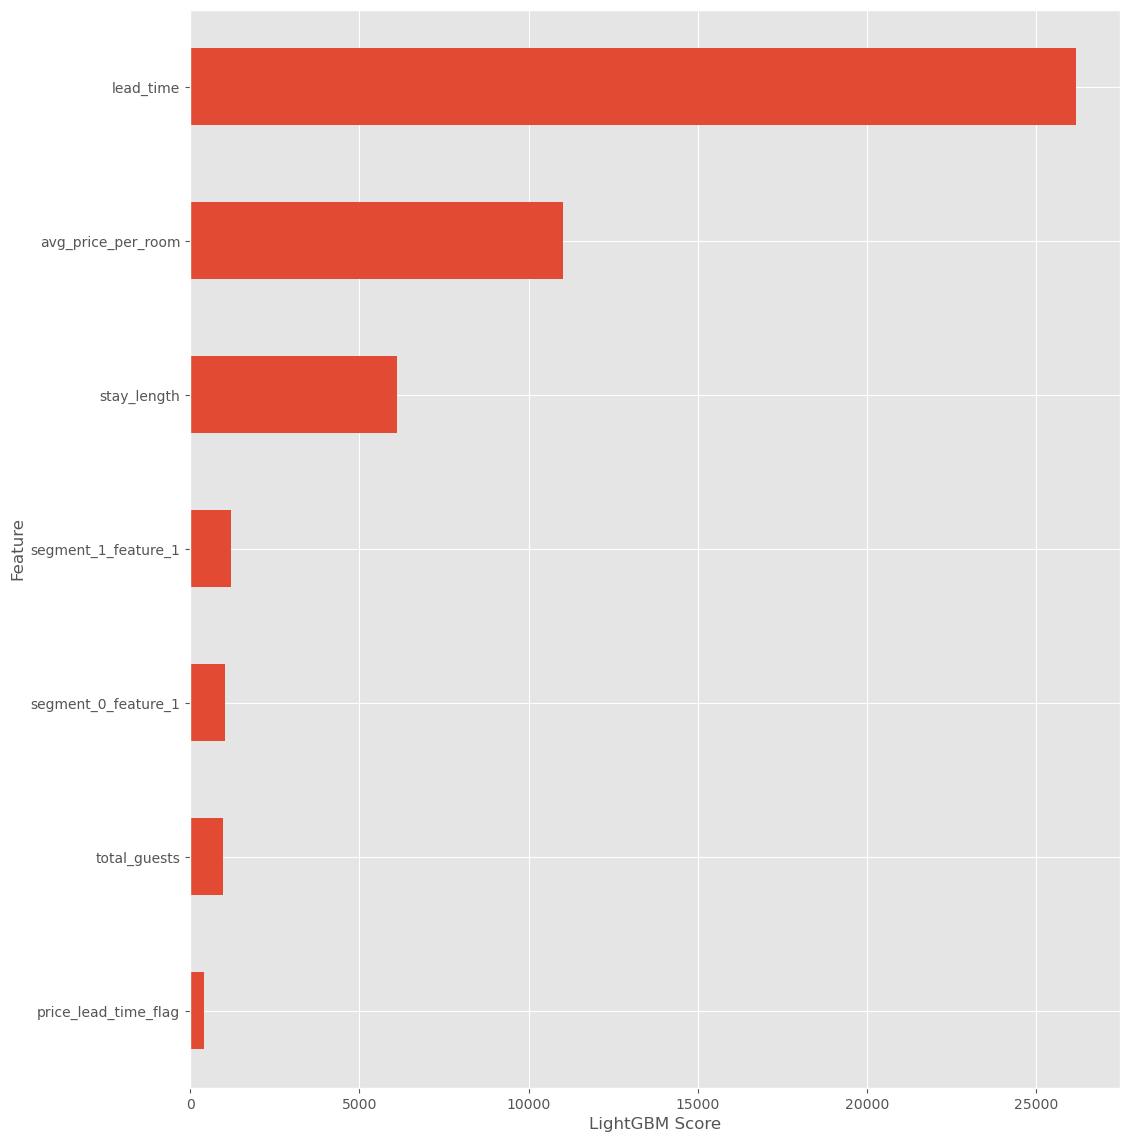

In [18]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('LightGBM Score')
plt.ylabel('Feature')
plt.show();

In [11]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['booking_status'] = lgb_preds_test
submission.head()

,id,booking_status
0,42100,0.231555
1,42101,0.297984
2,42102,0.147404
3,42103,0.044562
4,42104,0.461538


In [12]:
submission.to_csv('LightGBM_7_features_submission.csv', index = False)